<a href="https://colab.research.google.com/github/RanjKsan/Cyberbullying-detection-using-Transformer-model-and-XAI/blob/main/BERT%20and%20DISTILBERT%20with%20LIME%20and%20SHAP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

c7d144cd8b1cfb21fcd3776fa18a0686077060b9

In [ ]:
!pip install lime shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 6.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=d62e993310b123e65a684ac930da84c15040c0e43a008c59122b7342cfd504b7
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


**BERT**

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
from transformers import AutoTokenizer

# Load the dataset
df = pd.read_csv("/content/cyberbullying_tweets.csv")  # Replace with your dataset path

# Preprocess the dataset
# Encode the target column (cyberbullying_type)
label_encoder = LabelEncoder()
df['cyberbullying_type'] = label_encoder.fit_transform(df['cyberbullying_type'])

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(df['tweet_text'], df['cyberbullying_type'], test_size=0.2, random_state=42)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
def tokenize_texts(texts, tokenizer, max_length=128):
    return tokenizer(texts.tolist(), padding=True, truncation=True, max_length=max_length, return_tensors='pt')

train_encodings = tokenize_texts(X_train, tokenizer)
val_encodings = tokenize_texts(X_val, tokenizer)

# Convert labels to tensors
train_labels = torch.tensor(y_train.tolist())
val_labels = torch.tensor(y_val.tolist())

In [ ]:
import torch
import gc

In [ ]:
from transformers import BertForSequenceClassification, Trainer, TrainingArguments
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Define the function to clear memory
def clear_memory():
    torch.cuda.empty_cache()  # Empty the GPU cache
    gc.collect()  # Collect garbage

# Define a custom dataset class
class CyberbullyingDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

# Prepare dataset for Trainer API
train_dataset = CyberbullyingDataset(train_encodings, train_labels)
val_dataset = CyberbullyingDataset(val_encodings, val_labels)

# Load the BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_))

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
def compute_metrics(p):
    pred, labels = p
    preds = pred.argmax(axis=1)
    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='weighted')
    recall = recall_score(labels, preds, average='weighted')
    f1 = f1_score(labels, preds, average='weighted')
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=1,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    evaluation_strategy="epoch",  # Match save and evaluation strategies
    save_strategy="epoch",       # Ensures alignment with evaluation_strategy
    logging_dir='./logs',
    logging_steps=10,
    load_best_model_at_end=True
)

# Trainer initialization
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

# Train the model
trainer.train()

# Clear memory after training
clear_memory()

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: chaennie1880 (chaennie1880-c) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<ipython-input-6-0f2858a396bc>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


<ipython-input-6-0f2858a396bc>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


**LIME + BERT**


🔷 **LIME Explanation for BERT** 🔷


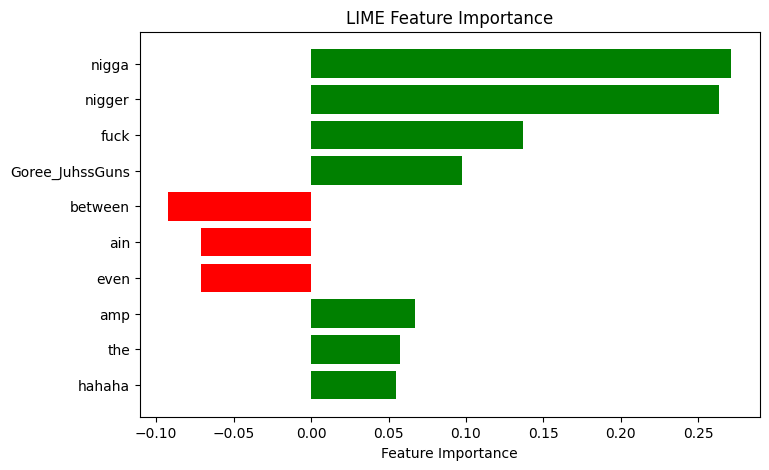

age: 0.0001
ethnicity: 0.9995
gender: 0.0001
not_cyberbullying: 0.0001
other_cyberbullying: 0.0001
religion: 0.0001

🔹 Local Explanation:
  nigga: 🟢 Positive (0.2713)
  nigger: 🟢 Positive (0.2632)
  fuck: 🟢 Positive (0.1366)
  Goree_JuhssGuns: 🟢 Positive (0.0975)
  between: 🔴 Negative (-0.0925)
  ain: 🔴 Negative (-0.0712)
  even: 🔴 Negative (-0.0711)
  amp: 🟢 Positive (0.0669)
  the: 🟢 Positive (0.0577)
  hahaha: 🟢 Positive (0.0551)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from lime.lime_text import LimeTextExplainer
from IPython.display import display, HTML

# Function to apply LIME for any transformer model (BERT, RoBERTa, DistilBERT)
def explain_with_lime(model, tokenizer, text_sample):
    """
    Apply LIME explanation on a given text for a given transformer model.

    Args:
        model: Transformer model (BERT, RoBERTa, DistilBERT)
        tokenizer: Tokenizer for the model
        text_sample: The text sample to explain

    Returns:
        LimeTextExplainer: The explainer object
    """
    class_names = label_encoder.classes_
    explainer = LimeTextExplainer(class_names=class_names)



    # Define prediction function for LIME
    def predict_fn(texts):
        inputs = tokenizer(
            texts,
            padding=True,
            truncation=True,
            max_length=128,
            return_tensors="pt"
        ).to(device)

        with torch.no_grad():
            outputs = model(**inputs)

        return torch.nn.functional.softmax(outputs.logits, dim=-1).cpu().numpy()

    # Generate LIME explanation
    explanation = explainer.explain_instance(
        text_sample,
        predict_fn,
        num_features=10,
        num_samples=100
    )

    # 1️⃣ **Bar Plot: Feature Importance**
    weights = dict(explanation.as_list())
    words = list(weights.keys())
    values = list(weights.values())

    plt.figure(figsize=(8, 5))
    plt.barh(words, values, color=['green' if v > 0 else 'red' for v in values])
    plt.xlabel("Feature Importance")
    plt.title("LIME Feature Importance")
    plt.gca().invert_yaxis()
    plt.show()

    # 2️⃣ **Probability Scores for Each Class**
    probabilities = predict_fn([text_sample])[0]
    for i, label in enumerate(class_names):
        print(f"{label}: {probabilities[i]:.4f}")

    # 3️⃣ **Local Explanation (Positive & Negative Contributions)**
    print("\n🔹 Local Explanation:")
    for word, weight in weights.items():
        print(f"  {word}: {'🟢 Positive' if weight > 0 else '🔴 Negative'} ({weight:.4f})")

    # Display highlighted HTML text
    display(HTML(explanation.as_html()))

    return explanation

# Sample text from validation set
sample_text = X_val.iloc[0]

# Apply LIME for each model
print("\n🔷 **LIME Explanation for BERT** 🔷")
explanation=explain_with_lime(model, tokenizer, sample_text)
clear_memory()

**LIME METRICS**

In [ ]:
target_label = explanation.available_labels()[0]

# 1️⃣ Intercept & Feature Contributions
print(f"Intercept for label {target_label}: {explanation.intercept[target_label]:.4f}\n")
print(f"Feature Contributions for label {target_label}:")
# explanation.local_exp is a dict mapping label index to list of (feature_index, weight) tuples.
# For text explanations, the "feature_index" is actually the word (as a string) when using LimeTextExplainer.
for word, weight in explanation.local_exp[target_label]:
    print(f"  {word}: {weight:.4f}")

# 2️⃣ Local Prediction
# The local prediction is the sum of the intercept and the contributions.
local_prediction = explanation.intercept[target_label] + sum(weight for _, weight in explanation.local_exp[target_label])
print(f"\nLocal Prediction (Intercept + Sum of Feature Contributions): {local_prediction:.4f}")

# 3️⃣ Local Fidelity (R²)
# If your LIME Explanation object computed a fidelity score, it is usually stored in 'explanation.score'
if hasattr(explanation, "score") and explanation.score is not None:
    print(f"\nLocal Fidelity (R²): {explanation.score:.4f}")
else:
    print("\nLocal Fidelity (R²) is not directly available in this explanation object.")
clear_memory()

Intercept for label 1: 0.3780

Feature Contributions for label 1:
  16: 0.2713
  18: 0.2632
  10: 0.1366
  0: 0.0975
  15: -0.0925
  3: -0.0712
  5: -0.0711
  17: 0.0669
  13: 0.0577
  1: 0.0551

Local Prediction (Intercept + Sum of Feature Contributions): 1.0916

Local Fidelity (R²): 0.6148


**SHAP + BERT**

In [ ]:
# Handle missing values and ensure string type
clean_X_val = X_val.dropna().astype(str)

# Get sample texts
sample_texts = clean_X_val.sample(n=50, random_state=42).tolist()
# Check for non-string entries
assert all(isinstance(text, str) for text in sample_texts), "Non-string values found in sample texts"
# For pandas Series, ensure proper string handling
sample_texts = X_val.str.strip().dropna().sample(n=50, random_state=42).tolist()

PartitionExplainer explainer: 51it [01:11,  1.55s/it]


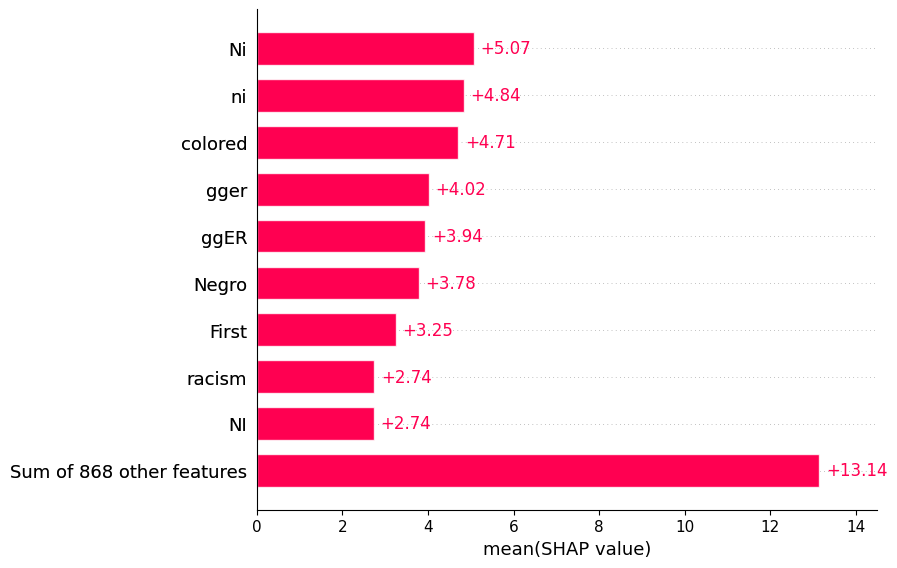

In [ ]:
import shap
import torch
import numpy as np

# Create a prediction function compatible with SHAP
def predictor(texts):
    # Ensure input is a list of strings
    if isinstance(texts, str):
        texts = [texts]

    # Tokenize and process input
    encodings = tokenizer(
        [str(text) for text in texts],
        padding=True,
        truncation=True,
        max_length=128,
        return_tensors='pt'
    )

    # Move tensors to the same device as the model
    input_ids = encodings['input_ids'].to(device)
    attention_mask = encodings['attention_mask'].to(device)

    # Disable gradient calculation for efficiency
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)

    # Return model logits
    return outputs.logits.cpu().numpy()

# Initialize SHAP explainer with correct masker
explainer = shap.Explainer(
    predictor,
    masker=shap.maskers.Text(tokenizer),
    output_names=label_encoder.classes_.tolist()
)

# Select a sample of texts to explain (reduce sample size if SHAP is too slow)
sample_texts = X_val.sample(n=50, random_state=42).tolist()

# Calculate SHAP values
shap_values = explainer(sample_texts)

# Visualization 1: Force plot for individual predictions
shap.plots.text(shap_values[0])  # Show explanation for first sample

# Visualization 3: Bar plot of mean absolute SHAP values
shap.plots.bar(shap_values.mean(0)[:, 1])

torch.cuda.empty_cache()


**SHAP METRICS**

In [ ]:
import numpy as np
import shap
import torch

def compute_shap_fidelity(explainer, model, tokenizer, texts, top_k=5):
    """
    Computes fidelity score for SHAP explanations on a BERT model using dataset texts.

    Parameters:
        explainer (shap.Explainer): SHAP explainer object.
        model (torch.nn.Module): Pre-trained BERT model.
        tokenizer (transformers.PreTrainedTokenizer): Tokenizer for the model.
        texts (list): List of texts (from dataset) to compute fidelity scores.
        top_k (int): Number of top important tokens to mask.

    Returns:
        float: Average fidelity score over all samples.
    """
    fidelity_scores = []

    for text in texts:
        # Tokenize input
        inputs = tokenizer(text, return_tensors="pt")
        input_ids = inputs["input_ids"].to(device)
        attention_mask = inputs["attention_mask"].to(device)

        # Get original prediction probability
        with torch.no_grad():
            logits = model(input_ids, attention_mask=attention_mask).logits
            orig_pred_prob = torch.softmax(logits, dim=-1).max().item()  # Max probability class

        # Compute SHAP values
        shap_values = explainer([text])

        # Extract absolute SHAP values per token
        token_shap_values = np.abs(shap_values.values[0])  # Shape: (seq_len, num_classes)
        token_importance = token_shap_values.sum(axis=1)  # Sum across classes for each token

        # Get top-k important tokens
        top_k_indices = np.argsort(token_importance)[-top_k:]

        # Mask top-k tokens by replacing them with [MASK]
        masked_input_ids = input_ids.clone()
        for idx in top_k_indices:
            masked_input_ids[0, idx] = tokenizer.mask_token_id

        # Get prediction on masked input
        with torch.no_grad():
            masked_logits = model(input_ids=masked_input_ids, attention_mask=attention_mask).logits
            masked_pred_prob = torch.softmax(masked_logits, dim=-1).max().item()

        # Compute fidelity score
        fidelity_score = 1 - abs(orig_pred_prob - masked_pred_prob) / orig_pred_prob
        fidelity_scores.append(fidelity_score)

    # Compute average fidelity score across all samples
    avg_fidelity_score = np.mean(fidelity_scores)

    return round(avg_fidelity_score, 4)


# Select a subset of validation data to compute fidelity scores (reduce size for efficiency)
sample_texts = X_val.sample(n=50, random_state=42).tolist()

# Compute Fidelity Score
fidelity_score = compute_shap_fidelity(explainer, model, tokenizer, sample_texts)
print("Average SHAP Fidelity Score:", fidelity_score)
clear_memory()

Average SHAP Fidelity Score: 0.7993


**DiatilBERT**

In [ ]:
def compute_metrics(p):
    pred, labels = p
    preds = pred.argmax(axis=1)
    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='weighted')
    recall = recall_score(labels, preds, average='weighted')
    f1 = f1_score(labels, preds, average='weighted')
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

In [ ]:
from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Load the DistilBERT model
model_distilbert = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=len(label_encoder.classes_))

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_distilbert.to(device)

# Define training arguments for DistilBERT training
training_args_distilbert = TrainingArguments(
    output_dir='./results_distilbert',
    num_train_epochs=1,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    evaluation_strategy="epoch",  # Evaluate at the end of each epoch
    logging_dir='./logs_distilbert',
    logging_steps=10,
    save_strategy="epoch",  # Save the model at the end of each epoch (matching evaluation strategy)
    load_best_model_at_end=True
)

# Trainer initialization for DistilBERT
trainer_distilbert = Trainer(
    model=model_distilbert,
    args=training_args_distilbert,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

# Train the DistilBERT model
trainer_distilbert.train()

# Clear memory after training
clear_memory()


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-6-0f2858a396bc>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


<ipython-input-6-0f2858a396bc>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


**LIME + DISTILBERT**


🔷 **LIME Explanation for DistilBERT** 🔷


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

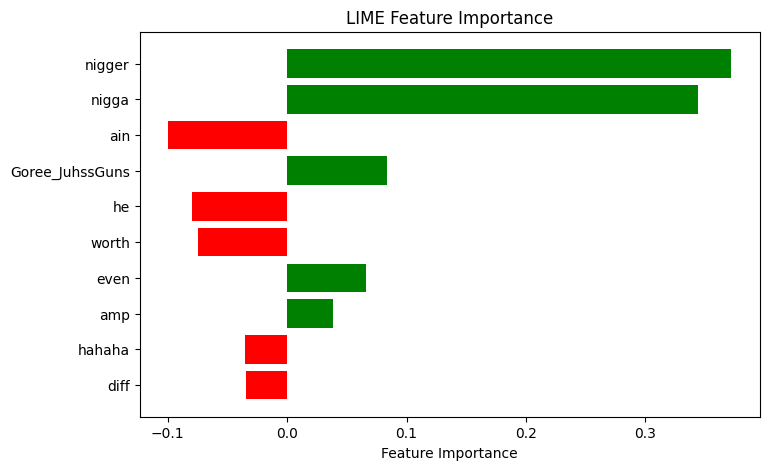

age: 0.0001
ethnicity: 0.9996
gender: 0.0001
not_cyberbullying: 0.0001
other_cyberbullying: 0.0001
religion: 0.0000

🔹 Local Explanation:
  nigger: 🟢 Positive (0.3720)
  nigga: 🟢 Positive (0.3439)
  ain: 🔴 Negative (-0.0999)
  Goree_JuhssGuns: 🟢 Positive (0.0838)
  he: 🔴 Negative (-0.0795)
  worth: 🔴 Negative (-0.0743)
  even: 🟢 Positive (0.0659)
  amp: 🟢 Positive (0.0381)
  hahaha: 🔴 Negative (-0.0352)
  diff: 🔴 Negative (-0.0341)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from lime.lime_text import LimeTextExplainer
from transformers import DistilBertTokenizer # Import the DistilBERT tokenizer

def explain_with_lime(model, tokenizer, text_sample):
    """
    Apply LIME explanation on a given text for a given transformer model.

    Args:
        model: Transformer model (BERT, RoBERTa, DistilBERT)
        tokenizer: Tokenizer for the model
        text_sample: The text sample to explain

    Returns:
        None (Displays visualizations)
    """
    class_names = label_encoder.classes_
    explainer = LimeTextExplainer(class_names=class_names)

    # Define prediction function for LIME
    def predict_fn(texts):
        # Use the correct tokenizer here (e.g., DistilBertTokenizer if using DistilBERT)
        # Now using the imported DistilBertTokenizer
        inputs = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')(
            texts,
            padding=True,
            truncation=True,
            max_length=128,
            return_tensors="pt"
        ).to(device)

        with torch.no_grad():
            # Pass only the required arguments to the model
            outputs = model(**{k: v for k, v in inputs.items() if k in model.forward.__code__.co_varnames})

        return torch.nn.functional.softmax(outputs.logits, dim=-1).cpu().numpy()

    # Generate LIME explanation
    explanation_distilbert = explainer.explain_instance(
        text_sample,
        predict_fn,
        num_features=10,
        num_samples=100
    )

    # 1️⃣ **Bar Plot: Feature Importance**
    weights = dict(explanation_distilbert.as_list())
    words = list(weights.keys())
    values = list(weights.values())

    plt.figure(figsize=(8, 5))
    plt.barh(words, values, color=['green' if v > 0 else 'red' for v in values])
    plt.xlabel("Feature Importance")
    plt.title("LIME Feature Importance")
    plt.gca().invert_yaxis()
    plt.show()

    # 2️⃣ **Probability Scores for Each Class**
    probabilities = predict_fn([text_sample])[0]
    for i, label in enumerate(class_names):
        print(f"{label}: {probabilities[i]:.4f}")

    # 3️⃣ **Local Explanation (Positive & Negative Contributions)**
    print("\n🔹 Local Explanation:")
    for word, weight in weights.items():
        print(f"  {word}: {'🟢 Positive' if weight > 0 else '🔴 Negative'} ({weight:.4f})")

    # Display highlighted HTML text
    display(HTML(explanation_distilbert.as_html()))
    # 4️⃣ **Highlighted Text (HTML)**
    return explanation_distilbert

# Sample text from validation set
sample_text = X_val.iloc[0]

print("\n🔷 **LIME Explanation for DistilBERT** 🔷")
explanation_distilbert=explain_with_lime(model_distilbert, tokenizer, sample_text)
clear_memory()

In [ ]:
# Retrieve top predicted label
target_label = explanation_distilbert.available_labels()[0]

# 1️⃣ Intercept & Feature Contributions
print(f"Intercept for label {target_label}: {explanation_distilbert.intercept[target_label]:.4f}\n")
print(f"Feature Contributions for label {target_label}:")
for word, weight in explanation_distilbert.local_exp[target_label]:
    print(f"  {word}: {weight:.4f}")

# 2️⃣ Local Prediction
local_prediction = explanation_distilbert.intercept[target_label] + sum(weight for _, weight in explanation_distilbert.local_exp[target_label])
print(f"\nLocal Prediction (Intercept + Sum of Feature Contributions): {local_prediction:.4f}")

# 3️⃣ Local Fidelity (R²)
if hasattr(explanation_distilbert, "score") and explanation_distilbert.score is not None:
    print(f"\nLocal Fidelity (R²): {explanation_distilbert.score:.4f}")
else:
    print("\nLocal Fidelity (R²) is not directly available in this explanation object.")

clear_memory()

Intercept for label 1: 0.4212

Feature Contributions for label 1:
  18: 0.3720
  16: 0.3439
  3: -0.0999
  0: 0.0838
  2: -0.0795
  6: -0.0743
  5: 0.0659
  17: 0.0381
  1: -0.0352
  14: -0.0341

Local Prediction (Intercept + Sum of Feature Contributions): 1.0018

Local Fidelity (R²): 0.7562


**SHAP + DISTILBERT**

PartitionExplainer explainer: 51it [00:50,  1.29s/it]


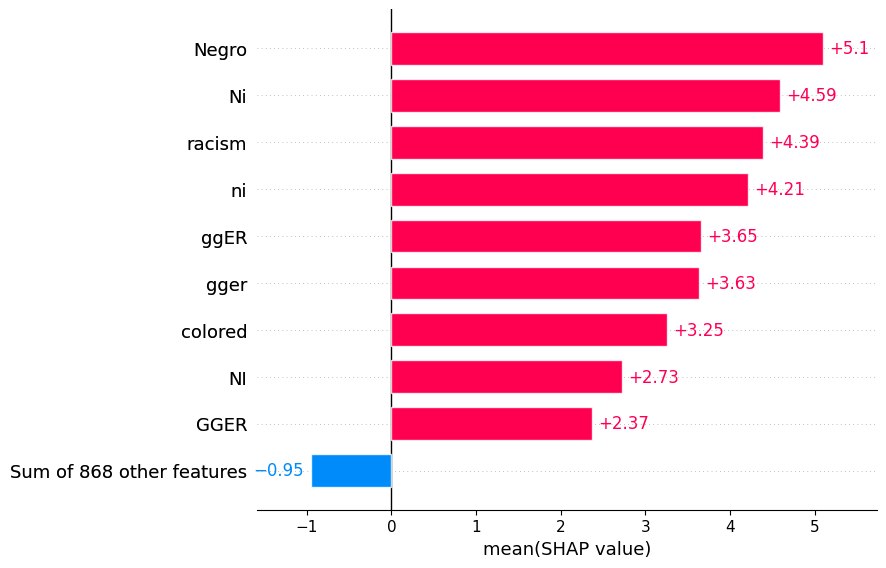

In [ ]:
import shap
import torch
import numpy as np

# Create a prediction function compatible with SHAP
def predictor_distilbert(texts):
    if isinstance(texts, str):
        texts = [texts]

    # Tokenize and process input
    encodings = tokenizer(
        [str(text) for text in texts],
        padding=True,
        truncation=True,
        max_length=128,
        return_tensors='pt'
    )

    # Move tensors to the same device as the model
    input_ids = encodings['input_ids'].to(device)
    attention_mask = encodings['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model_distilbert(input_ids, attention_mask=attention_mask)

    return outputs.logits.cpu().numpy()

# Initialize SHAP explainer
explainer_shap = shap.Explainer(
    predictor_distilbert,
    masker=shap.maskers.Text(tokenizer),
    output_names=label_encoder.classes_.tolist()
)

# Select a sample of texts to explain
sample_texts = X_val.sample(n=50, random_state=42).tolist()

# Compute SHAP values
shap_values = explainer_shap(sample_texts)

# Visualization 1: Force plot for individual predictions
shap.plots.text(shap_values[0])

# Visualization 2: Bar plot of mean absolute SHAP values
shap.plots.bar(shap_values.mean(0)[:, 1])

torch.cuda.empty_cache()


**SHAP METRICS**

In [ ]:
import numpy as np
import shap
import torch

def compute_shap_fidelity_distilbert(explainer, model, tokenizer, texts, top_k=5):
    """
    Computes fidelity score for SHAP explanations on a DistilBERT model.

    Parameters:
        explainer (shap.Explainer): SHAP explainer object.
        model (torch.nn.Module): Trained DistilBERT model.
        tokenizer (transformers.PreTrainedTokenizer): Tokenizer for DistilBERT.
        texts (list): List of texts (from dataset) to compute fidelity scores.
        top_k (int): Number of top important tokens to mask.

    Returns:
        float: Average fidelity score over all samples.
    """
    fidelity_scores = []

    for text in texts:
        # Tokenize input
        inputs = tokenizer(text, return_tensors="pt")
        input_ids = inputs["input_ids"].to(device)
        attention_mask = inputs["attention_mask"].to(device)

        # Get original prediction probability
        with torch.no_grad():
            logits = model(input_ids, attention_mask=attention_mask).logits
            orig_pred_prob = torch.softmax(logits, dim=-1).max().item()  # Max probability class

        # Compute SHAP values
        shap_values = explainer([text])

        # Extract absolute SHAP values per token
        token_shap_values = np.abs(shap_values.values[0])  # Shape: (seq_len, num_classes)
        token_importance = token_shap_values.sum(axis=1)  # Sum across classes for each token

        # Get top-k important tokens
        top_k_indices = np.argsort(token_importance)[-top_k:]

        # Mask top-k tokens by replacing them with [MASK]
        masked_input_ids = input_ids.clone()
        for idx in top_k_indices:
            masked_input_ids[0, idx] = tokenizer.mask_token_id

        # Get prediction on masked input
        with torch.no_grad():
            masked_logits = model(input_ids=masked_input_ids, attention_mask=attention_mask).logits
            masked_pred_prob = torch.softmax(masked_logits, dim=-1).max().item()

        # Compute fidelity score
        fidelity_score = 1 - abs(orig_pred_prob - masked_pred_prob) / orig_pred_prob
        fidelity_scores.append(fidelity_score)

    # Compute average fidelity score across all samples
    avg_fidelity_score = np.mean(fidelity_scores)

    return round(avg_fidelity_score, 4)


# Select a subset of validation data to compute fidelity scores (reduce size for efficiency)
sample_texts = X_val.sample(n=50, random_state=42).tolist()

# Compute Fidelity Score for DistilBERT
fidelity_score_distilbert = compute_shap_fidelity_distilbert(explainer_shap, model_distilbert, tokenizer, sample_texts)
print("Average SHAP Fidelity Score for DistilBERT:", fidelity_score_distilbert)
clear_memory()

Average SHAP Fidelity Score for DistilBERT: 0.7437
